We will use Neural Networks to predict music genres from short music clips, each lasting just 1 second. Our goal is to label these clips as classical, pop, rock, or blues. We 're feeding Mel-frequency cepstral coefficients (MFCCs) into Feedforward Neural Networks and mel spectrograms into Convolutional Neural Networks to make these predictions.

Importing the necessary libraries.

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt
import random
import librosa

# Exercise 1: Feedforward Neural Network

### Step 1: Loading the data

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: music_genre_data_di/
   creating: music_genre_data_di/test/
   creating: music_genre_data_di/test/melgrams/
  inflating: music_genre_data_di/test/melgrams/X.npy  
  inflating: music_genre_data_di/test/melgrams/labels.npy  
   creating: music_genre_data_di/test/mfccs/
  inflating: music_genre_data_di/test/mfccs/X.npy  
  inflating: music_genre_data_di/test/mfccs/labels.npy  
   creating: music_genre_data_di/train/
   creating: music_genre_data_di/train/melgrams/
  inflating: music_genre_data_di/train/melgrams/X.npy  
  inflating: music_genre_data_di/train/melgrams/labels.npy  
   creating: music_genre_data_di/train/mfccs/
  inflating: music_genre_data_di/train/mfccs/X.npy  
  inflating: music_genre_data_di/train/mfccs/labels.npy  
   creating: music_genre_data_di/val/
   creating: music_genre_data_di/val/melgrams/
  inflating: music_genre_data_di/val/melgrams/X.npy  
  inflating: music_genre_data_di/val/melgrams/labels.npy  
   creating: music_genre_data_

In [ ]:
mfcc_path = "/content/music_genre_data_di/"

X_train = np.load(os.path.join(mfcc_path, "train/mfccs/X.npy"))
labels_train = np.load(os.path.join(mfcc_path, "train/mfccs/labels.npy"))

X_val = np.load(os.path.join(mfcc_path, "val/mfccs/X.npy"))
labels_val = np.load(os.path.join(mfcc_path, "val/mfccs/labels.npy"))

X_test = np.load(os.path.join(mfcc_path, "test/mfccs/X.npy"))
labels_test = np.load(os.path.join(mfcc_path, "test/mfccs/labels.npy"))

Convert labels from strings to ints.

In [ ]:
unique_labels_train, Y_train = np.unique(labels_train, return_inverse=True)

unique_labels_val, Y_val = np.unique(labels_val, return_inverse=True)

unique_labels_test, Y_test = np.unique(labels_test, return_inverse=True)

Definition of a custom PyTorch dataset.

In [ ]:
class mfccDataset(Dataset):

  def __init__(self, x, y):
    self.x = torch.from_numpy(x)
    self.y = torch.from_numpy(y)
    self.len = len(self.y)

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

Creation of custom datasets using our data and loading of those datasets to dataloaders.

In [ ]:
train_dataset = mfccDataset(X_train, Y_train)
val_dataset = mfccDataset(X_val, Y_val)
test_dataset = mfccDataset(X_test, Y_test)

train_dataloader = DataLoader(dataset = train_dataset, batch_size=16, shuffle = True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size=16, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size=16)

### Step 2: Defintion of a Neural Network

We define a Feedforward Neural Network, using 4 linear layers.

In [ ]:
class fnn(nn.Module):

  def __init__(self, d_emb, num_classes):
    super(fnn, self).__init__()

    self.linear1 = nn.Linear(d_emb, 128)
    self.linear2 = nn.Linear(128, 32)
    self.linear3 = nn.Linear(32, num_classes)

  def forward(self, x):
    out = self.linear1(x)
    out = self.linear2(out)
    out = self.linear3(out)

    return out

### Step 3: Definition of a training process

We define a training function which, given the parameters for the training of a model, performs the training process.

In [ ]:
def training(num_epochs, optimizer, dataloader, criterion, model, device, val_dataloader=None, best_name=None, display_loss=False, scheduler=None, early_stopping=None):

  best_f1_score = -1
  consecutive_epochs_no_improvement = 0

  for epoch in range(num_epochs):

    losses = []

    for (x, y) in dataloader:

      x = x.to(dtype=torch.float32)
      x = x.to(device)
      y = y.to(device)

      # Forward pass
      outputs = model(x)
      loss = criterion(outputs, y)

      losses.append(loss.item())

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if val_dataloader:

      if early_stopping and epoch > 0:
        previous_f1_score = current_f1_score

      _, _, _, current_f1_score, _, _ = evaluation(val_dataloader, criterion, model, device)

      if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        torch.save(model.state_dict(), best_name)

      if early_stopping:
        if epoch > 0:
          if current_f1_score <= previous_f1_score:
            consecutive_epochs_no_improvement += 1
          else:
            consecutive_epochs_no_improvement = 0

          if consecutive_epochs_no_improvement >= early_stopping:
            return model

    if display_loss:
      print("Epoch", epoch)
      print("Training Loss:", np.mean(losses))

    if scheduler:
      scheduler.step()

  return model

### Step 4: Definition of an evaluation process

We define a function which, given a dataloader, a criterion and a model, evaluates the data of that dataloader, using the given loss function and the predictions created by the model.

In [ ]:
def evaluation(dataloader, criterion, model, device, print_output=False):

    losses = []
    total_predictions = []
    total_actuals = []

    model.eval()

    with torch.no_grad():

      for (x, y) in dataloader:

        x = x.to(dtype=torch.float32)
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        outputs = model(x)
        predictions = outputs.argmax(1)

        loss = criterion(outputs, y)
        losses.append(loss.item())

        total_predictions.extend(predictions.cpu().numpy())
        total_actuals.extend(y.cpu().numpy())

    mean_loss = np.mean(losses)
    f1 = f1_score(total_actuals, total_predictions, average='macro')
    accuracy = accuracy_score(total_actuals, total_predictions)
    cm = confusion_matrix(total_actuals, total_predictions, labels=[0,1,2,3])

    if print_output:
      print("\n----Evaluation:----\n")
      print("Mean Loss:", mean_loss)
      print("F1-Score (macro averaged):", f1)
      print("Accuracy:", accuracy)
      print("Confusion Matrix:\n", cm)

    model.train()

    return total_actuals, total_predictions, mean_loss, f1, accuracy, cm

### Step 5: Network training

In [ ]:
learning_rate = 0.002
criterion = nn.CrossEntropyLoss()
num_epochs = 30
d_emb = 26
num_classes = len(labels_train)

In [ ]:
device = 'cpu'

model = fnn(d_emb, num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

start = time.time()
model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, display_loss=True)
end = time.time()

cpu_time = end - start

_, _, _, _, _, _ = evaluation(test_dataloader, criterion, model, device, print_output = True)

Epoch 0
Training Loss: 2.1733278250694275
Epoch 1
Training Loss: 1.4001754760742187
Epoch 2
Training Loss: 1.3658276849985123
Epoch 3
Training Loss: 1.3452991503477096
Epoch 4
Training Loss: 1.3182832223176957
Epoch 5
Training Loss: 1.2901593619585037
Epoch 6
Training Loss: 1.2529200834035874
Epoch 7
Training Loss: 1.2226202994585038
Epoch 8
Training Loss: 1.2000910049676896
Epoch 9
Training Loss: 1.175966346859932
Epoch 10
Training Loss: 1.1380728763341903
Epoch 11
Training Loss: 1.1270524087548255
Epoch 12
Training Loss: 1.1038377928733825
Epoch 13
Training Loss: 1.082078717648983
Epoch 14
Training Loss: 1.0582186645269394
Epoch 15
Training Loss: 1.0482262670993805
Epoch 16
Training Loss: 1.038194636106491
Epoch 17
Training Loss: 1.0253545913100242
Epoch 18
Training Loss: 1.006977789402008
Epoch 19
Training Loss: 0.9941934126615525
Epoch 20
Training Loss: 1.0051484787464142
Epoch 21
Training Loss: 0.9920315903425216
Epoch 22
Training Loss: 0.9748536214232445
Epoch 23
Training Loss: 0

### Step 6: Network training with GPU

In [ ]:
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

model = fnn(d_emb, num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

start = time.time()
model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, display_loss=True)
end = time.time()

gpu_time = end - start

evaluation(test_dataloader, criterion, model, device, print_output = True)

print("CPU Time:", cpu_time)
print("GPU Time:", gpu_time)

Epoch 0
Training Loss: 2.206346526145935
Epoch 1
Training Loss: 1.41883240878582
Epoch 2
Training Loss: 1.392235975265503
Epoch 3
Training Loss: 1.3619970625638962
Epoch 4
Training Loss: 1.342189365029335
Epoch 5
Training Loss: 1.3223655605316162
Epoch 6
Training Loss: 1.2933681309223175
Epoch 7
Training Loss: 1.2636247777938843
Epoch 8
Training Loss: 1.2415854394435883
Epoch 9
Training Loss: 1.2110860925912856
Epoch 10
Training Loss: 1.1924183338880538
Epoch 11
Training Loss: 1.1624325281381607
Epoch 12
Training Loss: 1.1382830995321274
Epoch 13
Training Loss: 1.1140421542525292
Epoch 14
Training Loss: 1.082563273012638
Epoch 15
Training Loss: 1.064164595603943
Epoch 16
Training Loss: 1.0588230350613594
Epoch 17
Training Loss: 1.03734033703804
Epoch 18
Training Loss: 1.0181738817691803
Epoch 19
Training Loss: 1.0072115164995195
Epoch 20
Training Loss: 1.0050147460401058
Epoch 21
Training Loss: 0.9844251242280007
Epoch 22
Training Loss: 1.0015881282091141
Epoch 23
Training Loss: 0.9837

### Step 7: Model selection

We will now train the same neural network, but will evaluate the model produced after each epoch on the validation set and save the best one to evaluate it on the testing dataset.

In [ ]:
device = 'cpu'

model = fnn(d_emb, num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, display_loss=True, val_dataloader=val_dataloader, best_name='best_fnn_model')

model = fnn(d_emb, num_classes)
model.load_state_dict(torch.load('best_fnn_model'))
model = model.to(device)

_, _, _, _, _, _ = evaluation(test_dataloader, criterion, model, device, print_output = True)

Epoch 0
Training Loss: 2.068085023164749
Epoch 1
Training Loss: 1.4052488136291503
Epoch 2
Training Loss: 1.3803345251083374
Epoch 3
Training Loss: 1.3684109032154084
Epoch 4
Training Loss: 1.3521263593435286
Epoch 5
Training Loss: 1.3246397054195405
Epoch 6
Training Loss: 1.298447561264038
Epoch 7
Training Loss: 1.2728519701957703
Epoch 8
Training Loss: 1.2462084728479386
Epoch 9
Training Loss: 1.2271467158198357
Epoch 10
Training Loss: 1.1937050423026085
Epoch 11
Training Loss: 1.1673814204335213
Epoch 12
Training Loss: 1.140403377711773
Epoch 13
Training Loss: 1.11305190294981
Epoch 14
Training Loss: 1.0948264586925507
Epoch 15
Training Loss: 1.0649517560005188
Epoch 16
Training Loss: 1.052067904472351
Epoch 17
Training Loss: 1.0346333980560303
Epoch 18
Training Loss: 1.0318843579292298
Epoch 19
Training Loss: 1.0092538374662399
Epoch 20
Training Loss: 0.9961054047942162
Epoch 21
Training Loss: 0.9922027069330216
Epoch 22
Training Loss: 0.9825932440161705
Epoch 23
Training Loss: 0.9

# Exercise 2: Convolutional Neural Network

### Step 1: Loading the data (spectrograms)

Loading the data.

In [ ]:
melgram_path = "/content/music_genre_data_di/"

X_train = np.load(os.path.join(melgram_path, "train/melgrams/X.npy"))
labels_train = np.load(os.path.join(melgram_path, "train/melgrams/labels.npy"))

X_val = np.load(os.path.join(melgram_path, "val/melgrams/X.npy"))
labels_val = np.load(os.path.join(melgram_path, "val/melgrams/labels.npy"))

X_test = np.load(os.path.join(melgram_path, "test/melgrams/X.npy"))
labels_test = np.load(os.path.join(melgram_path, "test/melgrams/labels.npy"))

In [ ]:
unique_labels_train, Y_train = np.unique(labels_train, return_inverse=True)

unique_labels_val, Y_val = np.unique(labels_val, return_inverse=True)

unique_labels_test, Y_test = np.unique(labels_test, return_inverse=True)

In [ ]:
class melgramDataset(Dataset):

  def __init__(self, x, y):
    x = x[:, np.newaxis, :, :]
    self.x = torch.from_numpy(x)
    self.y = torch.from_numpy(y)
    self.len = len(self.y)

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [ ]:
train_dataset = melgramDataset(X_train, Y_train)
val_dataset = melgramDataset(X_val, Y_val)
test_dataset = melgramDataset(X_test, Y_test)

train_dataloader = DataLoader(dataset = train_dataset, batch_size=16, shuffle = True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size=16, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size=16)

We also visualize a random melgram from each class.

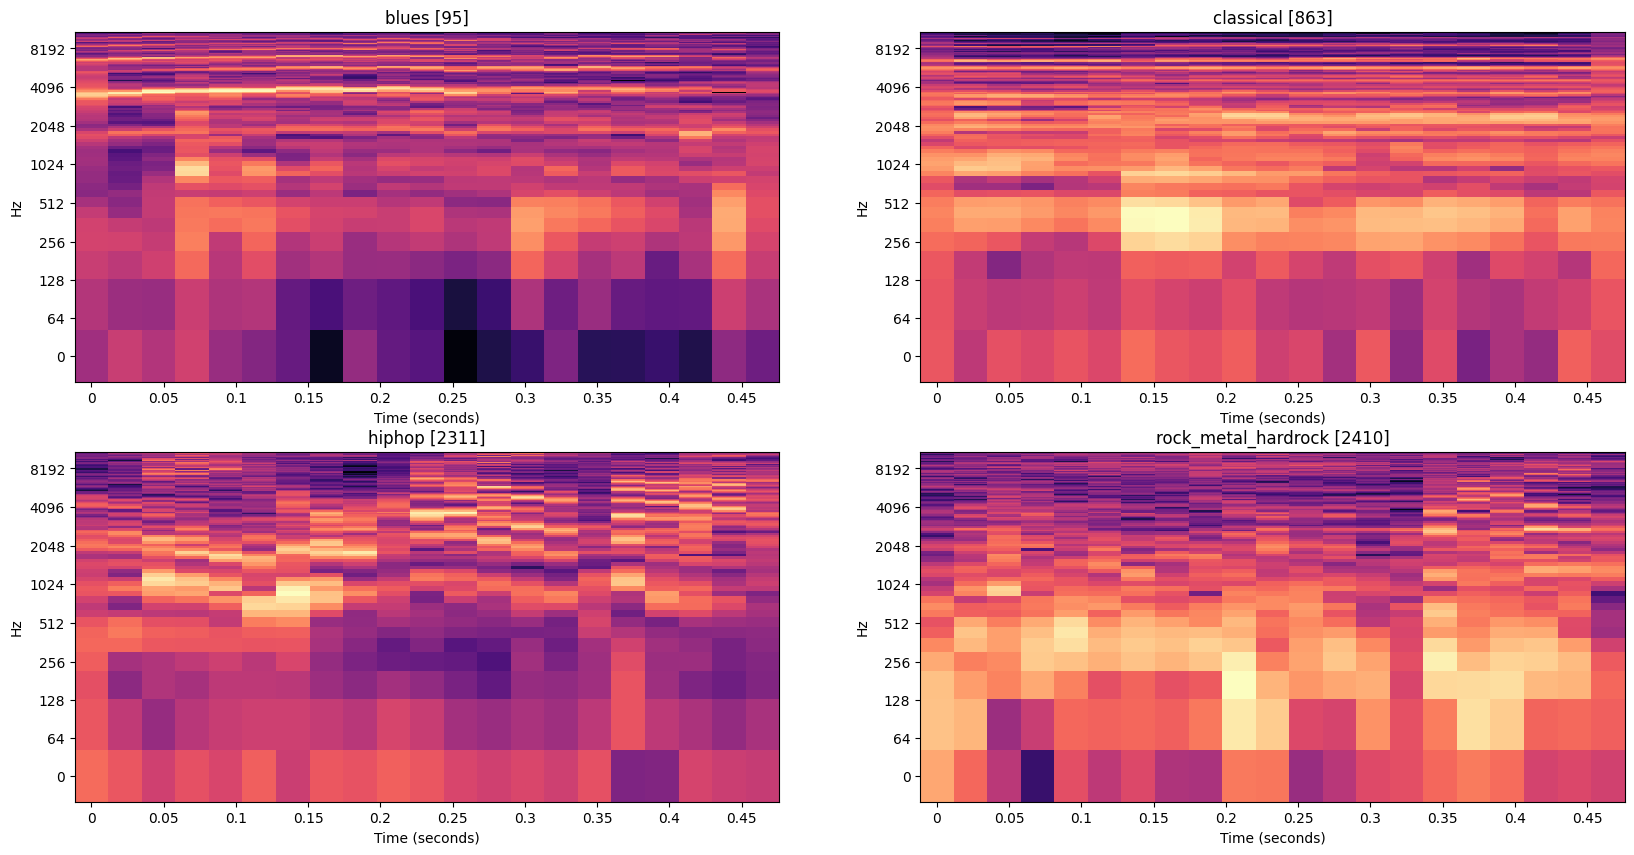

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

for i, music_kind in enumerate(unique_labels_train):

  indexes = np.where(labels_train == music_kind)[0]
  random_index = random.choice(indexes)
  librosa.display.specshow(X_train[random_index].T, ax=axs[i], x_axis='s', y_axis='log')
  axs[i].title.set_text(f"{music_kind} [{random_index}]")

### Step 2: Definition of a Convolutional Neural Network

We define a convolutional neural network with 5 channels, the output of which is given as an input to a fully-connected neural network consisted of 4 hidden layers.

In [ ]:
class cnn(nn.Module):

  def __init__(self, num_classes, kernel, padding, strides, pooling=False, pooling_kernel_size = None, activation_function=None, batch_norm=False, dropout=None):
    super(cnn, self).__init__()

    self.pooling = pooling
    self.activation_function = activation_function
    self.batch_norm = batch_norm

    self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel, padding=padding)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel, padding=padding)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=kernel, padding=padding)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=kernel, padding=padding)

    self.batch_norm1 = nn.BatchNorm2d(16)
    self.batch_norm2 = nn.BatchNorm2d(32)
    self.batch_norm3 = nn.BatchNorm2d(64)
    self.batch_norm4 = nn.BatchNorm2d(128)

    self.flatten = nn.Flatten()

    # calculation of the dimension of the last convolutional layer
    height = 21
    width = 128

    for i in range(4):
      height = (height - kernel + 2*padding) / strides + 1
      width = (width - kernel + 2*padding) / strides + 1

      if pooling:
        height = np.floor((height - pooling_kernel_size) / pooling_kernel_size + 1)
        width = np.floor((width - pooling_kernel_size) / pooling_kernel_size + 1)

    conv4_output_dimension = int(height * width * 128)

    self.dropout_value = dropout
    if self.dropout_value:
      self.dropout_function = torch.nn.Dropout(dropout)

    self.linear1 = nn.Linear(conv4_output_dimension, 1024)
    self.linear2 = nn.Linear(1024, 256)
    self.linear3 = nn.Linear(256, 32)
    self.linear4 = nn.Linear(32, num_classes)

  def forward(self, x):

    out = self.conv1(x)
    if self.batch_norm:
      out = self.batch_norm1(out)
    if self.activation_function:
      out = self.activation_function(out)
    if self.pooling:
      out = F.max_pool2d(out, kernel_size = 2)

    out = self.conv2(out)
    if self.batch_norm:
      out = self.batch_norm2(out)
    if self.activation_function:
      out = self.activation_function(out)
    if self.pooling:
      out = F.max_pool2d(out, kernel_size = 2)

    out = self.conv3(out)
    if self.batch_norm:
      out = self.batch_norm3(out)
    if self.activation_function:
      out = self.activation_function(out)
    if self.pooling:
      out = F.max_pool2d(out, kernel_size = 2)

    out = self.conv4(out)
    if self.batch_norm:
      out = self.batch_norm4(out)
    if self.activation_function:
      out = self.activation_function(out)
    if self.pooling:
      out = F.max_pool2d(out, kernel_size = 2)

    out = self.flatten(out)

    if self.activation_function:
      out = self.activation_function(out)
    if self.dropout_value:
      out = self.dropout_function(out)
    out = self.linear1(out)

    if self.activation_function:
      out = self.activation_function(out)
    if self.dropout_value:
      out = self.dropout_function(out)
    out = self.linear2(out)

    if self.activation_function:
      out = self.activation_function(out)
    if self.dropout_value:
      out = self.dropout_function(out)
    out = self.linear3(out)

    if self.dropout_value:
      out = self.dropout_function(out)
    if self.activation_function:
      out = self.activation_function(out)
    out = self.linear4(out)

    return out

### Step 3: Network training

The training function doesn't neet to be changed, since it can handle any type of network.

In [ ]:
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

kernel = 5
padding = 0
strides = 1

model = cnn(num_classes, kernel, padding, strides).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader = val_dataloader, best_name='best_cnn_model', display_loss=True)

model = cnn(num_classes, kernel, padding, strides)
model.load_state_dict(torch.load('best_cnn_model'))
model = model.to(device)

_, _, _, _, _, _ = evaluation(test_dataloader, criterion, model, device, print_output = True)

Epoch 0
Training Loss: nan
Epoch 1
Training Loss: nan
Epoch 2
Training Loss: nan
Epoch 3
Training Loss: nan
Epoch 4
Training Loss: nan
Epoch 5
Training Loss: nan
Epoch 6
Training Loss: nan
Epoch 7
Training Loss: nan
Epoch 8
Training Loss: nan
Epoch 9
Training Loss: nan
Epoch 10
Training Loss: nan
Epoch 11
Training Loss: nan
Epoch 12
Training Loss: nan
Epoch 13
Training Loss: nan
Epoch 14
Training Loss: nan
Epoch 15
Training Loss: nan
Epoch 16
Training Loss: nan
Epoch 17
Training Loss: nan
Epoch 18
Training Loss: nan
Epoch 19
Training Loss: nan
Epoch 20
Training Loss: nan
Epoch 21
Training Loss: nan
Epoch 22
Training Loss: nan
Epoch 23
Training Loss: nan
Epoch 24
Training Loss: nan
Epoch 25
Training Loss: nan
Epoch 26
Training Loss: nan
Epoch 27
Training Loss: nan
Epoch 28
Training Loss: nan
Epoch 29
Training Loss: nan

----Evaluation:----

Mean Loss: nan
F1-Score (macro averaged): 0.09529411764705882
Accuracy: 0.23546511627906977
Confusion Matrix:
 [[324   0   0   0]
 [297   0   0   0]

It is evident that the network can not be trained, which is due to the training loss constantly increasing. The final F1-score on the testin dataset is only 9%.

### Step 4: Pooling and padding

That 's why we include max pooling with a kernel size of 2 and padding of 2.

In [ ]:
kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader = val_dataloader, best_name='best_cnn_model', display_loss=True)

model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size)
model.load_state_dict(torch.load('best_cnn_model'))
model = model.to(device)

_, _, _, _, _, _ = evaluation(test_dataloader, criterion, model, device, print_output = True)

Epoch 0
Training Loss: 1.8088870388269425
Epoch 1
Training Loss: 1.2650153729319573
Epoch 2
Training Loss: 1.1226712214946746
Epoch 3
Training Loss: 1.01609743475914
Epoch 4
Training Loss: 0.9399868273735046
Epoch 5
Training Loss: 0.8967597053945064
Epoch 6
Training Loss: 0.8458709082007408
Epoch 7
Training Loss: 0.8074191878736019
Epoch 8
Training Loss: 0.7788842234015465
Epoch 9
Training Loss: 0.749342170059681
Epoch 10
Training Loss: 0.7197715517878532
Epoch 11
Training Loss: 0.6978339375555516
Epoch 12
Training Loss: 0.6699455158412456
Epoch 13
Training Loss: 0.642427942827344
Epoch 14
Training Loss: 0.6245133157074452
Epoch 15
Training Loss: 0.591976486518979
Epoch 16
Training Loss: 0.5619587448984384
Epoch 17
Training Loss: 0.5366131885349751
Epoch 18
Training Loss: 0.5064324473589659
Epoch 19
Training Loss: 0.4742392461746931
Epoch 20
Training Loss: 0.43965472385287285
Epoch 21
Training Loss: 0.4162399112805724
Epoch 22
Training Loss: 0.38040547881275416
Epoch 23
Training Loss: 

Maximum pooling is a pooling operation that calculates the maximum value in each moving window of each feature map.
This results in down sampled feature maps that highlight the most prominent feature in each window we examine.

Padding is a technique used to preserve the spatial dimensions of the input array after convolution operations on a feature map, such as maximum pooling used here.
Padding involves adding extra pixels around the border of the input feature map before convolution.

It is evident that when using maximum pooling along with the appropriate padding, the features highlighted result in a very improved performance. Here, the F1-score has been increased to more than 69%.

### Step 5: Optimization algorithms

In [ ]:
kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size).to(device)

optimizers = [(torch.optim.Adadelta(model.parameters(), lr=learning_rate), "adadelta"),
              (torch.optim.Adagrad(model.parameters(), lr=learning_rate), "adagrad"),
              (torch.optim.Adam(model.parameters(), lr=learning_rate), "adam"),
              (torch.optim.AdamW(model.parameters(), lr=learning_rate), "adamw"),
              (torch.optim.Adamax(model.parameters(), lr=learning_rate), "adamax"),
              (torch.optim.ASGD(model.parameters(), lr=learning_rate), "asgd"),
              (torch.optim.NAdam(model.parameters(), lr=learning_rate), "nadam"),
              (torch.optim.RAdam(model.parameters(), lr=learning_rate), "radam"),
              (torch.optim.SGD(model.parameters(), lr=learning_rate), "sgd")]

for optimizer, optimizer_name in optimizers:
    print("\n-----", optimizer_name, "-----")

    model_new = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader = val_dataloader, best_name='best_cnn_model')

    model_new = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size)
    model_new.load_state_dict(torch.load('best_cnn_model'))
    model_new = model_new.to(device)

    _, _, _, _, _, _ = evaluation(test_dataloader, criterion, model_new, device, print_output = True)


----- adadelta -----

----Evaluation:----

Mean Loss: 0.8873841422068518
F1-Score (macro averaged): 0.6319008743696839
Accuracy: 0.6300872093023255
Confusion Matrix:
 [[145  33  56  90]
 [ 37 246   9   5]
 [ 34  10 261  51]
 [ 82  19  83 215]]

----- adagrad -----

----Evaluation:----

Mean Loss: 0.7617955166757848
F1-Score (macro averaged): 0.7500770438493627
Accuracy: 0.7420058139534884
Confusion Matrix:
 [[220  12  34  58]
 [ 29 258   1   9]
 [ 46   5 279  26]
 [ 99   8  28 264]]

----- adam -----

----Evaluation:----

Mean Loss: 0.8788677071574226
F1-Score (macro averaged): 0.6801781251262276
Accuracy: 0.6765988372093024
Confusion Matrix:
 [[228  45  11  40]
 [  6 289   1   1]
 [ 98   9 225  24]
 [134  60  16 189]]

----- adamw -----

----Evaluation:----

Mean Loss: 0.7689262231484294
F1-Score (macro averaged): 0.7440924171164586
Accuracy: 0.7441860465116279
Confusion Matrix:
 [[161  12  36 115]
 [ 14 271   1  11]
 [ 24   6 283  43]
 [ 46  12  32 309]]

----- adamax -----

----Eva

| Metrics  | Adadelta | Adagrad | Adam   | AdamW  | Adamax | ASGD   | Nadam  | RAdam  | SGD    |
|----------|----------|---------|--------|--------|--------|--------|--------|--------|--------|
| Accuracy | 0.6301   | 0.7420  | 0.6766 | 0.7442 | 0.7544 | 0.7551 | 0.6948 | 0.2355 | 0.2355 |
| F1-Score | 0.6319   | 0.7501  | 0.6802 | 0.7441 | 0.7595 | 0.7595 | 0.7055 | 0.0953 | 0.0953 |

We can see that:

- The best optimizers in terms of both accuracy and F1-score are Adagrad, AdamW, Adamax, and ASGD, with relatively higher values compared to others.

- The worst performing optimizers, based on the low accuracy and F1-score, are RAdam and SGD. These optimizers seem to have poor convergence, resulting in significantly lower performance.
Adadelta, Adam, and Nadam have intermediate performance, with moderate accuracy and F1-scores.

- Overall, using one of the best performing optimizers for this problem, we can increase F1-score from about 69% to about 76%.

# Exercise 3: Improving Performance

### Step 1: Reproducibility

Add a seed to every possible library.

In [ ]:
def torch_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

torch_seed()

Using the seed we provided above, we now train our base model, in order to use its results as reference later.

In [ ]:
kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader = val_dataloader, best_name='best_cnn_model')

model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size)
model.load_state_dict(torch.load('best_cnn_model'))
model = model.to(device)

_, _, _, _, _, _ = evaluation(test_dataloader, criterion, model, device, print_output = True)


----Evaluation:----

Mean Loss: 0.8278560511406435
F1-Score (macro averaged): 0.7171873212481279
Accuracy: 0.715843023255814
Confusion Matrix:
 [[187  32  33  72]
 [  5 279   4   9]
 [ 37   8 280  31]
 [ 84  24  52 239]]


So the F1-Score without performing any optimizations is 71.7%.

### Step 2: Activation functions

We will try different activation functions in both the convolutional and the linear layers, in order to help the model learn non-linear relations of the data.

In [ ]:
kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

activations = [(torch.nn.ELU(), "elu"),
              (torch.nn.Hardsigmoid(), "hardsigmoid"),
              (torch.nn.Hardswish(), "hardswish"),
              (torch.nn.LeakyReLU(), "leakyrelu"),
              (torch.nn.ReLU(), "relu"),
              (torch.nn.Sigmoid(), "sigmoid"),
              (torch.nn.Softplus(), "softplus"),
              (torch.nn.SiLU(), "silu")]

for activation, activation_name in activations:
    print("\n-----", activation_name, "-----")

    model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, activation_function=activation).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader = val_dataloader, best_name='best_cnn_model')

    model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, activation_function=activation)
    model.load_state_dict(torch.load('best_cnn_model'))
    model = model.to(device)

    _, _, _, _, _, _ = evaluation(test_dataloader, criterion, model, device, print_output = True)


----- elu -----

----Evaluation:----

Mean Loss: 0.7082252456958211
F1-Score (macro averaged): 0.7148306159670834
Accuracy: 0.7165697674418605
Confusion Matrix:
 [[150  19  49 106]
 [ 36 253   5   3]
 [ 39   2 281  34]
 [ 55  13  29 302]]

----- hardsigmoid -----

----Evaluation:----

Mean Loss: 7.052287506502728
F1-Score (macro averaged): 0.09529411764705882
Accuracy: 0.23546511627906977
Confusion Matrix:
 [[324   0   0   0]
 [297   0   0   0]
 [356   0   0   0]
 [399   0   0   0]]

----- hardswish -----

----Evaluation:----

Mean Loss: 0.718550049472427
F1-Score (macro averaged): 0.7371394578722081
Accuracy: 0.7311046511627907
Confusion Matrix:
 [[214  28  30  52]
 [ 35 257   5   0]
 [ 55   2 265  34]
 [ 86  12  31 270]]

----- leakyrelu -----

----Evaluation:----

Mean Loss: 0.9556499678035115
F1-Score (macro averaged): 0.5901652427707996
Accuracy: 0.5959302325581395
Confusion Matrix:
 [[122  20  93  89]
 [ 57 206  27   7]
 [ 13  10 312  21]
 [ 49  18 152 180]]

----- relu -----

-

| Activation Function | Accuracy | F1-Score |
|---------------------|----------|----------|
| ELU                 | 0.7166   | 0.7148   |
| HardSigmoid         | 0.2355   | 0.0953   |
| HardSwish           | 0.7311   | 0.7371   |
| LeakyReLU           | 0.5959   | 0.5902   |
| ReLU                | 0.6613   | 0.6582   |
| Sigmoid             | 0.2899   | 0.1124   |
| Softplus            | 0.7100   | 0.7117   |
| SiLU                | 0.6722   | 0.6684   |

We can see that:

- The best-performing activation functions based on both accuracy and F1-score seem to be HardSwish, ELU (Exponential Linear Unit) and Softplus, with an accuracy and F1-score of more than 71-73%.

- The worst-performing activation functions based on both accuracy and F1-score are HardSigmoid and Sigmoid, with very low values for both metrics, that are worse even than random chance. These activation functions are not suitable for the given dataset of melgrams.

- Overall, by using an activation function such as HardSwish we can improve F1-score from 71.7% to 73.7%.

### Step 3: Learning rate scheduler

We will now use different learning rate schedulers that are able to adjust the learning rate between epochs or iterations as the training progresses, using the history of loss values.

In [ ]:
kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

lambdalr = lambda epoch: 0.9 ** epoch

model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

schedulers = [(torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambdalr, verbose=True), "lambdalr"),
              (torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True), "exponentiallr"),
              (torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8, verbose=True), "steplr"),
              (torch.optim.lr_scheduler.LinearLR(optimizer, verbose=True), "linearlr"),
              (torch.optim.lr_scheduler.PolynomialLR(optimizer, verbose=True), "polynomiallr")]

for scheduler, scheduler_name in schedulers:
    print("\n-----", scheduler_name, "-----")

    model_new = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader = val_dataloader, best_name='best_cnn_model', scheduler=scheduler)

    model_new = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size)
    model_new.load_state_dict(torch.load('best_cnn_model'))
    model_new = model_new.to(device)

    _, _, _, _, _, _ = evaluation(test_dataloader, criterion, model_new, device, print_output = True)

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.

----- lambdalr -----
Adjusting learning rate of group 0 to 1.8000e-03.
Adjusting learning rate of group 0 to 1.6200e-03.
Adjusting learning rate of group 0 to 1.4580e-03.
Adjusting learning rate of group 0 to 1.3122e-03.
Adjusting learning rate of group 0 to 1.1810e-03.
Adjusting learning rate of group 0 to 1.0629e-03.
Adjusting learning rate of group 0 to 9.5659e-04.
Adjusting learning rate of group 0 to 8.6093e-04.
Adjusting learning rate of group 0 to 7.7484e-04.
Adjusting learning rate of group 0 to 6.9736e-04.
Adjusting learning rate of group 0 to 6.2762e-04.
Adjusting learning rate of group 0 to 5.6486e-04.
Adjusting learning rate of group 0 to 5.0837e-04.
Adjusting learning rate of group 0 to 4.5754e-04.
Adjusting learning rate of g

| Learning rate scheduler | Accuracy | F1-Score |
|-------------------------|----------|----------|
| LambdaLR                | 0.6780   | 0.6877   |
| ExponentialLR           | 0.6831   | 0.6922   |
| StepLR                  | 0.6882   | 0.6959   |
| LinearLR                | 0.6896   | 0.6967   |
| PolynomialLR            | 0.6911   | 0.6981   |

We can see that:

- All schedulers perform almost equally well, but do not improve the performance of the base model.

- From the output of the scheduler functions, it is evident that the learning rate is constantly decreasing.

### Step 4: Batch Normalization

We will now add batch normalization 2d layers before every activation function of a convolutional layer, to let the input have the same statistical properties before being fed into a layer or between different epochs.

In [ ]:
kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader = val_dataloader, best_name='best_cnn_model')

model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True)
model.load_state_dict(torch.load('best_cnn_model'))
model = model.to(device)

_, _, _, _, _, _ = evaluation(test_dataloader, criterion, model, device, print_output = True)


----Evaluation:----

Mean Loss: 0.6122246084594016
F1-Score (macro averaged): 0.7704583312890394
Accuracy: 0.7696220930232558
Confusion Matrix:
 [[208  16  55  45]
 [ 15 279   1   2]
 [ 29   2 317   8]
 [ 82  22  40 255]]


We can see that there is a significant improvement of the F1-Score, from 71.7% to 77%, when using batch normalization.

### Step 5: Regularization

(i) We will now try to reduce the difference between training and validation loss, using different weight decay values in the optimizer. We are going to evaluate the results on the validation dataset, so that we can then choose the best weight decay value and combine it with the appropriate dropout to perform the evaluation on the test set.

In [ ]:
kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True).to(device)

for weight_decay in [0.001, 0.0001, 0.00001, 0.000001]:

    print("\n---- weight decay =", weight_decay, "----")

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader = val_dataloader, best_name='best_cnn_model')

    model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True)
    model.load_state_dict(torch.load('best_cnn_model'))
    model = model.to(device)

    _, _, _, _, _, _ = evaluation(val_dataloader, criterion, model, device, print_output = True)


---- weight decay = 0.001 ----

----Evaluation:----

Mean Loss: 0.5233419981598854
F1-Score (macro averaged): 0.7975765037690191
Accuracy: 0.79875
Confusion Matrix:
 [[132  19  19  30]
 [ 13 182   0   5]
 [ 20   0 166  14]
 [ 23   8  10 159]]

---- weight decay = 0.0001 ----

----Evaluation:----

Mean Loss: 0.5481264179944992
F1-Score (macro averaged): 0.8074092791797903
Accuracy: 0.80625
Confusion Matrix:
 [[152  15  22  11]
 [ 18 180   0   2]
 [ 21   0 172   7]
 [ 40   5  14 141]]

---- weight decay = 1e-05 ----

----Evaluation:----

Mean Loss: 0.7679793711006642
F1-Score (macro averaged): 0.7960496389500074
Accuracy: 0.795
Confusion Matrix:
 [[137  13  22  28]
 [ 17 178   0   5]
 [ 27   0 163  10]
 [ 28   6   8 158]]

---- weight decay = 1e-06 ----

----Evaluation:----

Mean Loss: 0.7631309822201728
F1-Score (macro averaged): 0.7961075669093916
Accuracy: 0.79875
Confusion Matrix:
 [[124  18  23  35]
 [ 10 187   0   3]
 [ 22   0 166  12]
 [ 22   7   9 162]]


(ii) We will also try to reduce the difference between training and validation loss, using dropout in the linear layers. We are going to evaluate the results on the validation dataset, so that we can then choose the best weight decay value and combine it with the appropriate dropout to perform the evaluation on the test set.

In [ ]:
kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

for dropout in [0.4, 0.5, 0.6]:

    print("\n---- dropout =", dropout, "----")

    model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True, dropout=dropout).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader = val_dataloader, best_name='best_cnn_model')

    model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True, dropout=dropout)
    model.load_state_dict(torch.load('best_cnn_model'))
    model = model.to(device)

    _, _, _, _, _, _ = evaluation(val_dataloader, criterion, model, device, print_output = True)


---- dropout = 0.4 ----

----Evaluation:----

Mean Loss: 0.5544826883077622
F1-Score (macro averaged): 0.8027170900367777
Accuracy: 0.8025
Confusion Matrix:
 [[143  19  20  18]
 [  9 189   0   2]
 [ 28   1 164   7]
 [ 39   6   9 146]]

---- dropout = 0.5 ----

----Evaluation:----

Mean Loss: 0.5907908129692078
F1-Score (macro averaged): 0.7966792067704459
Accuracy: 0.7975
Confusion Matrix:
 [[137  21  21  21]
 [  8 191   0   1]
 [ 33   3 156   8]
 [ 29   7  10 154]]

---- dropout = 0.6 ----

----Evaluation:----

Mean Loss: 0.5419619852304458
F1-Score (macro averaged): 0.8034271994372678
Accuracy: 0.805
Confusion Matrix:
 [[126  10  30  34]
 [ 13 180   0   7]
 [ 16   0 175   9]
 [ 23   2  12 163]]


We will now try the best values that we found on the validation dataset for weight decay (0.0001) and dropout (0.6), separately and together, and evaluate the results on the testing dataset.

In [ ]:
num_epochs = 60

kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

for weight_decay, dropout in [(0.0001, None), (0, 0.6), (0.0001, 0.6)]:

    print("\n-------\nweight decay =", weight_decay, "\ndropout =", dropout, "\n-------")

    model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True, dropout=dropout).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader = val_dataloader, best_name='best_cnn_model')

    model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True, dropout=dropout)
    model.load_state_dict(torch.load('best_cnn_model'))
    model = model.to(device)

    _, _, _, _, _, _ = evaluation(test_dataloader, criterion, model, device, print_output = True)


-------
weight decay = 0.0001 
dropout = None 
-------

----Evaluation:----

Mean Loss: 0.6673206988245596
F1-Score (macro averaged): 0.7682939813740196
Accuracy: 0.7688953488372093
Confusion Matrix:
 [[204  26  61  33]
 [  5 290   0   2]
 [ 29   4 312  11]
 [ 92  23  32 252]]

-------
weight decay = 0 
dropout = 0.6 
-------

----Evaluation:----

Mean Loss: 0.8887153432143922
F1-Score (macro averaged): 0.7532098178162132
Accuracy: 0.751453488372093
Confusion Matrix:
 [[206  16  51  51]
 [ 14 281   2   0]
 [ 30   2 315   9]
 [106  21  40 232]]

-------
weight decay = 0.0001 
dropout = 0.6 
-------

----Evaluation:----

Mean Loss: 0.5921286217283545
F1-Score (macro averaged): 0.7723823506885346
Accuracy: 0.7710755813953488
Confusion Matrix:
 [[193  17  51  63]
 [ 12 284   0   1]
 [ 42   2 304   8]
 [ 72  11  36 280]]


We can see that when using both weight decay = 0.0001 and dropout = 0.6, we achieve an F1-score = 77.2%.

### Step 6: Training Efficiency

#### Batch Size

We will try different values of batch size and compare the results and the execution time for each of those values.

In [ ]:
num_epochs = 30

kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

for power in range(1, 1+7):

    batch_size = 2**power

    print("\n---- batch size =", batch_size, "----")

    train_dataloader_for_testing = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
    val_dataloader_for_testing = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = True)
    test_dataloader_for_testing = DataLoader(dataset = test_dataset, batch_size = batch_size)

    model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    start = time.time()
    model = training(num_epochs, optimizer, train_dataloader_for_testing, criterion, model, device, val_dataloader_for_testing, best_name='best_cnn_model')
    end = time.time()

    model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True)
    model.load_state_dict(torch.load('best_cnn_model'))
    model = model.to(device)

    _, _, _, _, _, _ = evaluation(test_dataloader_for_testing, criterion, model, device, print_output = True)

    print("\nTime:", end - start)


---- batch size = 2 ----

----Evaluation:----

Mean Loss: 1.3649373613242373
F1-Score (macro averaged): 0.7264989110334692
Accuracy: 0.717296511627907
Confusion Matrix:
 [[204  16  23  81]
 [ 31 256   3   7]
 [ 48   3 281  24]
 [113  14  26 246]]

Time: 319.47007608413696

---- batch size = 4 ----

----Evaluation:----

Mean Loss: 1.119427055692129
F1-Score (macro averaged): 0.7674940822215854
Accuracy: 0.7630813953488372
Confusion Matrix:
 [[202  13  29  80]
 [ 14 274   2   7]
 [ 26   5 298  27]
 [ 82  11  30 276]]

Time: 171.26928281784058

---- batch size = 8 ----

----Evaluation:----

Mean Loss: 0.8043194281995797
F1-Score (macro averaged): 0.7764300374962707
Accuracy: 0.7776162790697675
Confusion Matrix:
 [[184  16  42  82]
 [  2 289   1   5]
 [ 23   6 304  23]
 [ 57  19  30 293]]

Time: 100.95861983299255

---- batch size = 16 ----

----Evaluation:----

Mean Loss: 0.7368326032057751
F1-Score (macro averaged): 0.7663369283193681
Accuracy: 0.7609011627906976
Confusion Matrix:
 [[25

We can see that very small and very larg batch sizes, e.g. 2 and 128 result in worse performance. This is due to the very small/large number of samples used to train the model, that can result in either overfitting or underfitting. Thus, a value close to the median, such as 16 or 32 results in imrpoved performance.

However, larger batch sizes also result in smaller training times, as less iterations are being done through the entire dataset.

In [ ]:
num_epochs = 30

kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

for early_stopping in [3, 7, 10]:

    print("\n---- early stopping =", early_stopping, "----")

    model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    start = time.time()
    model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader, best_name='best_cnn_model', early_stopping=early_stopping)
    end = time.time()

    model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True)
    model.load_state_dict(torch.load('best_cnn_model'))
    model = model.to(device)

    _, _, _, _, _, _ = evaluation(test_dataloader, criterion, model, device, print_output = True)
    print("\nTime:", end - start)


---- early stopping = 3 ----

----Evaluation:----

Mean Loss: 0.6525998740716902
F1-Score (macro averaged): 0.7703079565347442
Accuracy: 0.7645348837209303
Confusion Matrix:
 [[255  16  32  21]
 [ 22 275   0   0]
 [ 54   1 293   8]
 [119  23  28 229]]

Time: 19.762622117996216

---- early stopping = 7 ----

----Evaluation:----

Mean Loss: 0.5916111944974292
F1-Score (macro averaged): 0.7939893115909995
Accuracy: 0.7863372093023255
Confusion Matrix:
 [[255  16  16  37]
 [ 15 281   0   1]
 [ 59   3 282  12]
 [104   9  22 264]]

Time: 57.467527866363525

---- early stopping = 10 ----

----Evaluation:----

Mean Loss: 0.6031697693627415
F1-Score (macro averaged): 0.7929060644515298
Accuracy: 0.7856104651162791
Confusion Matrix:
 [[262  10  16  36]
 [ 17 277   0   3]
 [ 57   4 279  16]
 [100  17  19 263]]

Time: 58.114108085632324


Early stopping allows our model to be trained faster, since the training is stopped when no performance imrpovement has been seen for a certain number of epochs. Small values for early stopping may lead to a wrong, premature stopping, before the training has reached a good state. However, larger values for early stopping result to larger training times, so the trade-off should be examined accordingly. 7 consecutive epochs with no performance improvement seem to be a good value for early stopping for this problem.

# Exercise 4: Testing

### Step 1: Inference

The evaluation function defined during exercise 1 will be used for this step too.

### Step 2: Downloading music

In [ ]:
!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl
!python3 -m pip install -U yt-dlp #youtube-dl has not been updated for some years and
                                  #does not work anymore, so we use an alternative

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [81.0 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,079 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu foc

Functions from `youtube.py` to download the music of a youtube video.

In [ ]:
window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21


def download_youtube(url):
    # command = f'youtube-dl --extract-audio --audio-format wav --output temp.wav --postprocessor-args "-ar 8000" ' + url + " --quiet"
    command = f'yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" ' + url + " --quiet"
    os.system(command)


def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url, name, kind):
    download_youtube(url)
    melgrams = get_melgrams("temp.wav")
    np.save(kind+"_"+name+"_melgrams.npy", melgrams)
    os.remove("temp.wav")


Construct a list of youtube videos and download their music.

In [ ]:
blues_urls = {
    "BBKing_HowBlueCanYouGet":"https://www.youtube.com/watch?v=l45f28PzfCI",
    "BBKing_TheThrillIsGone": "https://www.youtube.com/watch?v=kpC69qIe02E",
    "HowlinWolf_Evil":"https://www.youtube.com/watch?v=osnDVXlhxPw",
}

classical_urls = {
    "Chopin_Nocturne9":"https://www.youtube.com/watch?v=9E6b3swbnWg",
    "Vivaldi_TheFourSeasonsWinter":"https://www.youtube.com/watch?v=TZCfydWF48c",
    "Mozart_EineKleineNachtmusik":"https://www.youtube.com/watch?v=oy2zDJPIgwc",
}

hiphop_urls = {
    "Madonna_HungUp":"https://www.youtube.com/watch?v=EDwb9jOVRtU",
    "Eminem_LoseYourself":"https://www.youtube.com/watch?v=x0c_5zNu8pk",
    "NickiMinaj_Anaconda":"https://www.youtube.com/watch?v=2ArN3HfSebw",
}

rock_urls = {
    "Placebo_EveryYouEveryMe" : "https://www.youtube.com/watch?v=OMaycNcPsHI",
    "GunsNRoses_SweetChildOMine":"https://www.youtube.com/watch?v=1w7OgIMMRc4",
    "PinkFloyd_ComfortablyNumb":"https://www.youtube.com/watch?v=_FrOQC-zEog",
}

for key in blues_urls:
    youtube_to_melgram(blues_urls[key], key, "blues")

for key in classical_urls:
    youtube_to_melgram(classical_urls[key], key, "classical")

for key in hiphop_urls:
    youtube_to_melgram(hiphop_urls[key], key, "hiphop")

for key in rock_urls:
    youtube_to_melgram(rock_urls[key], key, "rock")

### Step 3: Predictions

Train a model using the best features found during exercises 2 and 3, evaluate it on the testing dataset and then use it on the downloaded music from youtube.

In [ ]:
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

torch_seed()

train_dataloader = DataLoader(dataset = train_dataset, batch_size=32, shuffle = True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size=32, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size=32)

num_epochs = 30

kernel = 5
padding = 2
strides = 1
pooling_kernel_size = 2

activation_function = torch.nn.Hardswish()

model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True, activation_function=activation_function).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model = training(num_epochs, optimizer, train_dataloader, criterion, model, device, val_dataloader, best_name='best_cnn_model', early_stopping=7)

model = cnn(num_classes, kernel, padding, strides, pooling=True, pooling_kernel_size=pooling_kernel_size, batch_norm=True, activation_function=activation_function)
model.load_state_dict(torch.load('best_cnn_model'))
model = model.to(device)

_, _, _, _, _, _ = evaluation(test_dataloader, criterion, model, device, print_output = True)


----Evaluation:----

Mean Loss: 0.6098438262246376
F1-Score (macro averaged): 0.762883060345894
Accuracy: 0.7572674418604651
Confusion Matrix:
 [[212  13  41  58]
 [ 28 268   0   1]
 [ 45   2 295  14]
 [ 92  14  26 267]]


So our best model after all performance improvements scores 76.2% (F1-Score) on the testing dataset.

In [ ]:
def plot(trues, predictions, song_title):
  x = range(0, len(predictions))
  plt.figure(figsize=(10, 5))
  ylabels = ['Blues', 'Classical', 'HipHop', 'Rock']
  plt.yticks(range(0, 4), ylabels)
  plt.plot(x, predictions, "mo", markersize=5)
  plt.title(song_title)
  plt.show()

We will now try to predict the class for each of the 12 songs that were downloaded from YouTube. Note that we classify the input based on the class with the highest number of classifications, regardless of the proportion or percentage (i.e. even if accuraacy is below 50%). This way, we can determine the class by comparing the counts of each class. By identifying the class with the largest count, we assign the input to that particular class. This approach prioritizes the class with the maximum number of instances, irrespective of any specific threshold or percentage requirement.

We proceed to make predictions for the three Blues songs.

The first one (How Blue Can You Get) is correctly recognized as a Blues song with 205/313 seconds predicted correctly. The second most prominent class is HipHop with 55/205 seconds, which is understandable, since as Stephen Thomas Erlewine, an American music critic and senior editor for the online music database AllMusic, has commented, it contains hip-hop beats.

The second one is correctly recognized as a Blues song, with 270/325 seconds predicted correctly.

The third one is also correctly recognized as a Blues song, with 140/178 seconds predicted correctly.


----Evaluation:----

Mean Loss: 0.7764924526214599
F1-Score (macro averaged): 0.19787644787644787
Accuracy: 0.6549520766773163
Confusion Matrix:
 [[205  12  55  41]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]


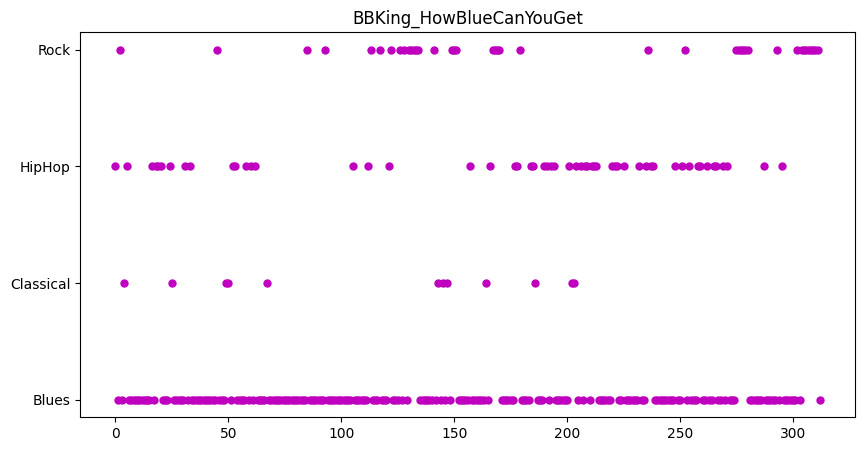


----Evaluation:----

Mean Loss: 0.5630819770422849
F1-Score (macro averaged): 0.226890756302521
Accuracy: 0.8307692307692308
Confusion Matrix:
 [[270   4   6  45]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]


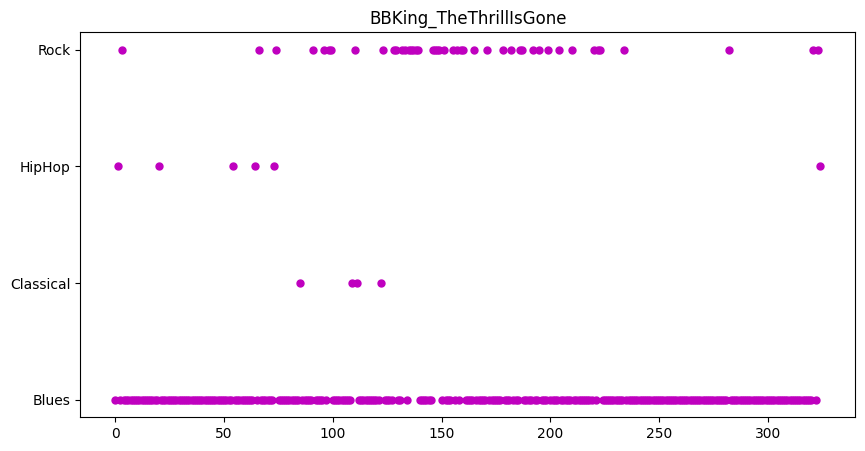


----Evaluation:----

Mean Loss: 0.7607225428024927
F1-Score (macro averaged): 0.220125786163522
Accuracy: 0.7865168539325843
Confusion Matrix:
 [[140   6  31   1]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]


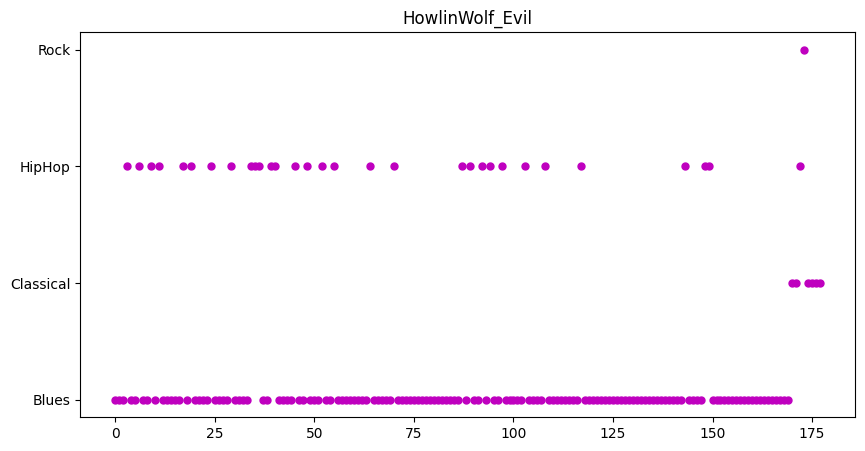

In [ ]:
for song_title in blues_urls:
    song = np.load("blues_"+song_title+"_melgrams.npy")
    song_labels = np.full(len(song), 0)
    song_dataset = melgramDataset(song, song_labels)
    song_dataloader = DataLoader(dataset=song_dataset, batch_size=32, shuffle=False)
    trues, predictions, _, _, _, _ = evaluation(song_dataloader, criterion, model, device, print_output=True)
    plot(trues, predictions, song_title)

We proceed to make predictions for the three Classical songs.

The first one (Nocturne 9 by Chopen) is correctly recognized as a Classical song, with an impressive 269/270 seconds predicted correctly. This can be explained due to the very clear piano sounds contained in this song.

The second one is also correctly recognized as a Classical song, with 375/564 seconds predicted correctly.

The third one is also correctly recognized as a Classical song, with 241/348 seconds predicted correctly.


----Evaluation:----

Mean Loss: 0.031166320537320442
F1-Score (macro averaged): 0.49907235621521334
Accuracy: 0.9962962962962963
Confusion Matrix:
 [[  0   0   0   0]
 [  1 269   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]


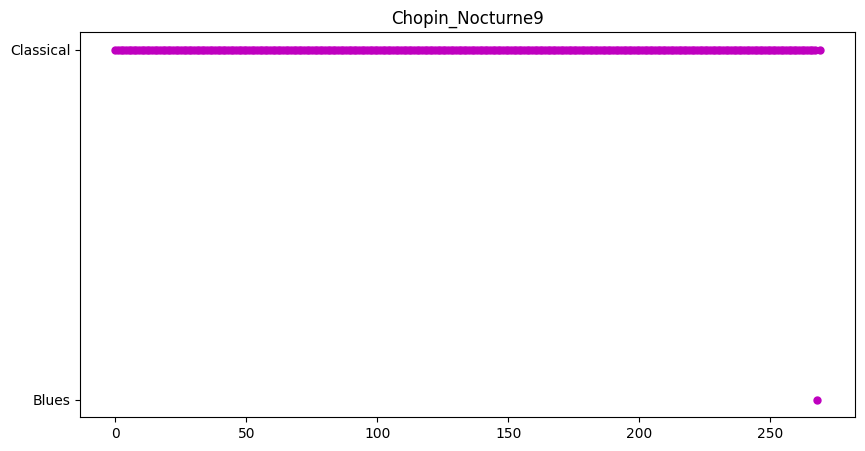


----Evaluation:----

Mean Loss: 1.0419138881067436
F1-Score (macro averaged): 0.19968051118210864
Accuracy: 0.6648936170212766
Confusion Matrix:
 [[  0   0   0   0]
 [141 375   8  40]
 [  0   0   0   0]
 [  0   0   0   0]]


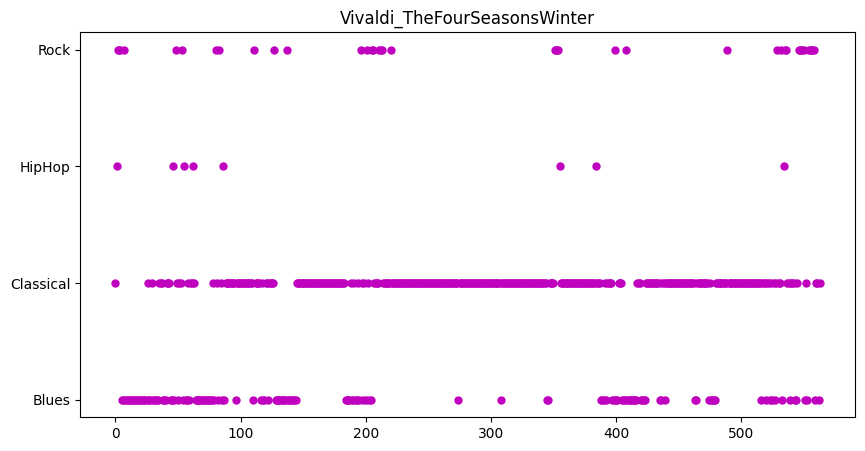


----Evaluation:----

Mean Loss: 0.8201043605804443
F1-Score (macro averaged): 0.27277872099603845
Accuracy: 0.6925287356321839
Confusion Matrix:
 [[  0   0   0   0]
 [100 241   7   0]
 [  0   0   0   0]
 [  0   0   0   0]]


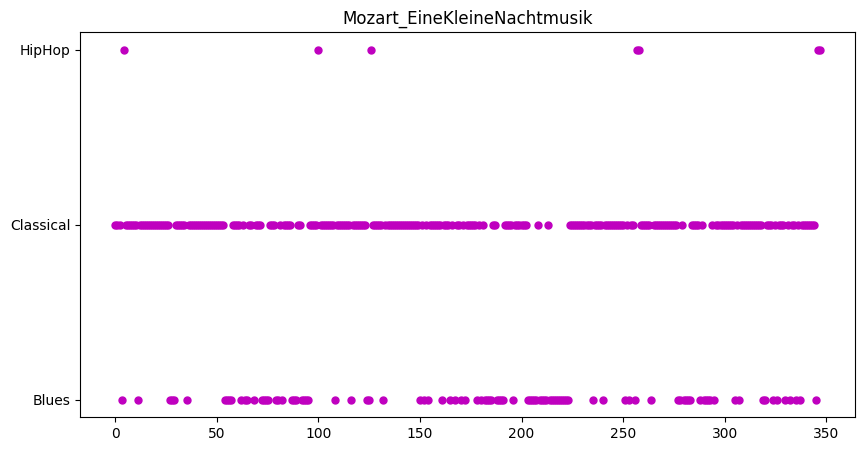

In [ ]:
for song_title in classical_urls:
    song = np.load("classical_"+song_title+"_melgrams.npy")
    song_labels = np.full(len(song), 1)
    song_dataset = melgramDataset(song, song_labels)
    song_dataloader = DataLoader(dataset=song_dataset, batch_size=32, shuffle=False)
    trues, predictions, _, _, _, _ = evaluation(song_dataloader, criterion, model, device, print_output=True)
    plot(trues, predictions, song_title)

We proceed to make predictions for the three HipHop songs.

The first one (Madonna's Hung up) is correctly recognized as a HipHop song with 136/334 seconds being predicted correctly. 104/334 are predicted as Rock, which is also expected, since the song contains Rock characteristics, and even Madonna herself has performed live Rock versions of this song, for example during the 2008 leg of the Sticky & Sweet Tour.

The second one (Eminem's Lose Yourself) is also correctly recognized as a HipHop song, with 264/329 seconds predicted correctly. This is very expected, due to the rapping, the rhythmic, the rhyming speech and the rhythmic beatboxing. The beginning of the song is predicted as Classical, which can be attributed to the very clear piano music playing for some seconds without any vocals, before the rapping begins.

The third one (Anaconda by Nicki Minaj) is also correctly recognized as a HipHop song, with 208/243 seconds predicted correctly. This is very expected too, due to the rapping, the rhythmic, the rhyming speech and the rhythmic beatboxing.


----Evaluation:----

Mean Loss: 2.388533277945085
F1-Score (macro averaged): 0.14468085106382977
Accuracy: 0.40718562874251496
Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [ 77  17 136 104]
 [  0   0   0   0]]


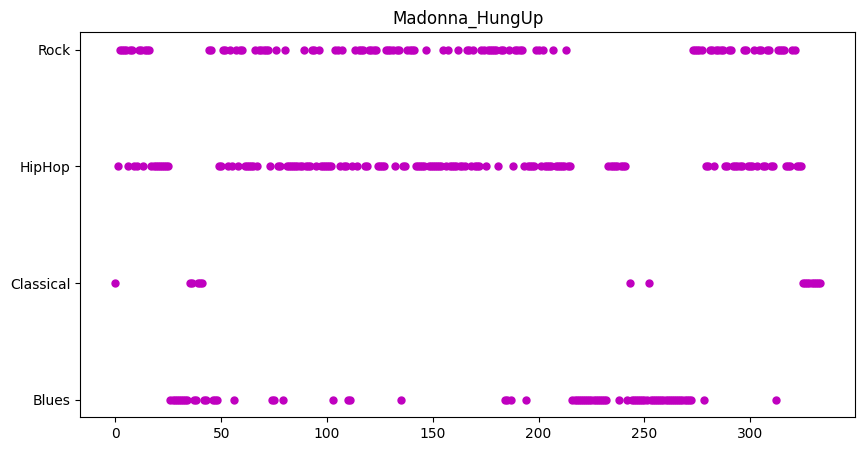


----Evaluation:----

Mean Loss: 1.8085171160372822
F1-Score (macro averaged): 0.22259696458684655
Accuracy: 0.8024316109422492
Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [ 24  32 264   9]
 [  0   0   0   0]]


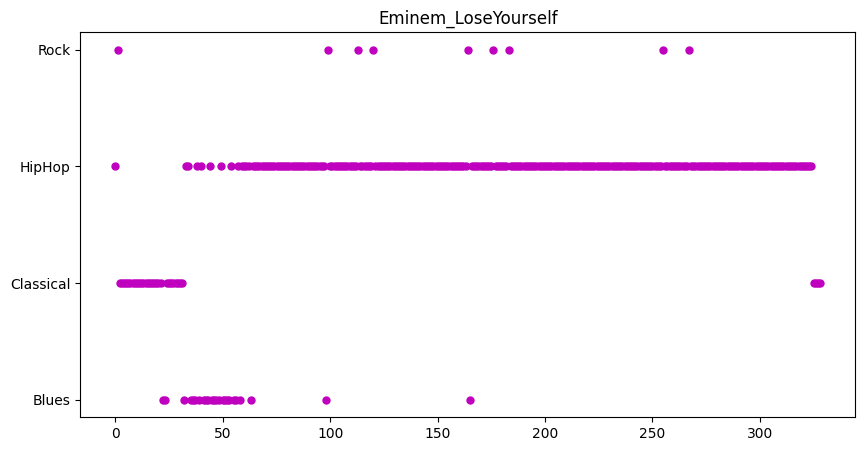


----Evaluation:----

Mean Loss: 0.8582166118754281
F1-Score (macro averaged): 0.22174840085287845
Accuracy: 0.7969348659003831
Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [ 42   5 208   6]
 [  0   0   0   0]]


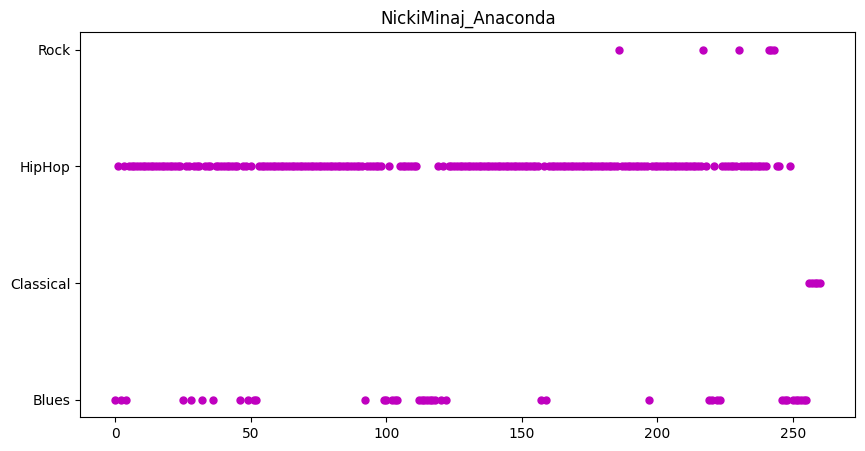

In [ ]:
for song_title in hiphop_urls:
    song = np.load("hiphop_"+song_title+"_melgrams.npy")
    song_labels = np.full(len(song), 2)
    song_dataset = melgramDataset(song, song_labels)
    song_dataloader = DataLoader(dataset=song_dataset, batch_size=32, shuffle=False)
    trues, predictions, _, _, _, _ = evaluation(song_dataloader, criterion, model, device, print_output=True)
    plot(trues, predictions, song_title)

We proceed to make predictions for the three Rock songs.

The first one (Every You Every Me by Placebo) is correctly recognized as a Rock song with an impressive 195/216 seconds being predicted correctly. It is one of the most representative Rock songs out there, which might explain this outstanding score.

The second one is also correctly recognized as a Rock song, with 184/303 seconds predicted correctly.

The third one (Comfortably Numb by Pink Floyd) is also correctly recognized as a Rock song, with 224/414 seconds predicted correctly. However, we notice that 148/414 seconds are predicted as Blues. This song is "softer" than usual rock songs, which might explaing why there are so many seconds classified as Blues. We should also keep in mind that Pink Floyd's music was heavily influenced by the blues genre, and even the band is named after two blues artists, Pink Anderson and Floyd Council.


----Evaluation:----

Mean Loss: 0.5340893609183175
F1-Score (macro averaged): 0.2372262773722628
Accuracy: 0.9027777777777778
Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  9  10   2 195]]


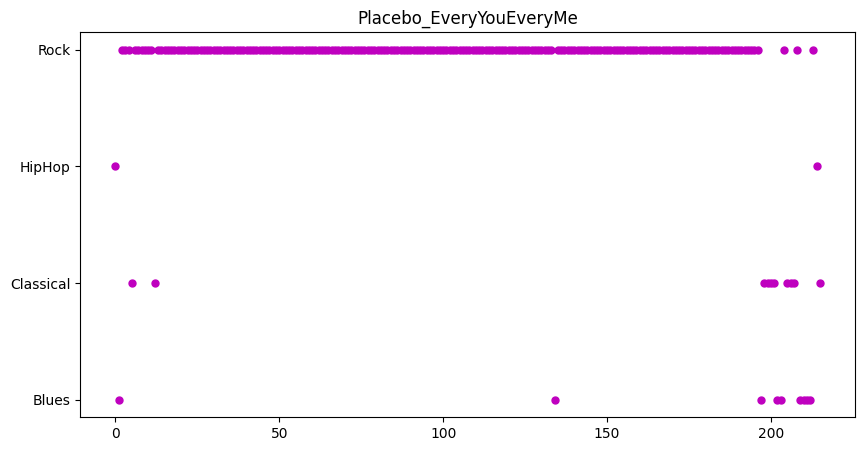


----Evaluation:----

Mean Loss: 1.392069274187088
F1-Score (macro averaged): 0.2518822724161533
Accuracy: 0.6072607260726073
Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [ 87  32   0 184]]


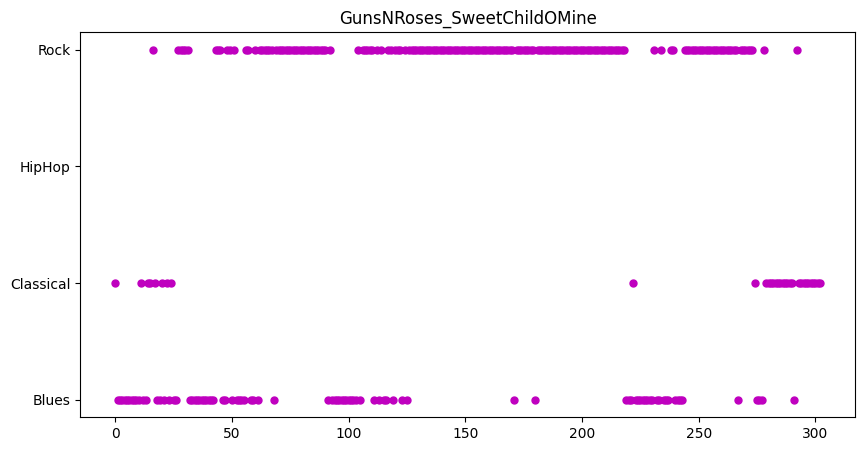


----Evaluation:----

Mean Loss: 0.905530361028818
F1-Score (macro averaged): 0.1755485893416928
Accuracy: 0.5410628019323671
Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [148  39   3 224]]


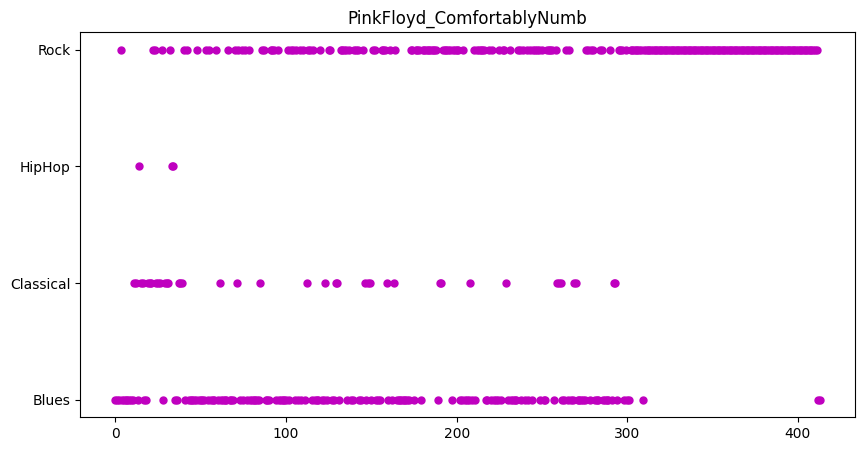

In [ ]:
for song_title in rock_urls:
    song = np.load("rock_"+song_title+"_melgrams.npy")
    song_labels = np.full(len(song), 3)
    song_dataset = melgramDataset(song, song_labels)
    song_dataloader = DataLoader(dataset=song_dataset, batch_size=32, shuffle=False)
    trues, predictions, _, _, _, _ = evaluation(song_dataloader, criterion, model, device, print_output=True)
    plot(trues, predictions, song_title)

In conclusion, all 12 selected songs were identified correctly by the classifier.

The weighted accuracy across all the 3837 seconds of all 12 songs is 70.6%, generally close to the 75% calculated using the testing dataset.

However, as mentioned before, accuracy for a specific song does not have to be >= 50% in order to classify the song into a specific class, since we classify the song into the class with the highest number of predicted instances. That's why 12 out of our 12 predictions are correct, even though accruacy remains close to 70%.